# Maternal Health Risk Stratification
### Ordinal Cumulative Classification for Prenatal Care Decision Support

## Table of Contents
1. [Executive Summary](#1-executive-summary)
2. [Project Setup and Data Source](#2-project-setup-and-data-source)
3. [Data Quality and Preparation](#3-data-quality-and-preparation)
4. [Exploratory Data Analysis](#4-exploratory-data-analysis)
5. [Modeling Strategy](#5-modeling-strategy)
6. [Evaluation and Interpretation](#6-evaluation-and-interpretation)
7. [Feature Importance](#7-feature-importance)
8. [Conclusions and Future Work](#8-conclusions-and-future-work)

## 1. Executive Summary

Maternal and infant mortality still claims approximately **295,000 maternal lives every year** (WHO, 2023), underscoring the urgency of early-risk identification during pregnancy. This notebook translates the accompanying Maternal Risk report into an executable workflow that clinicians and data scientists can review end to end.

- **Objective.** Predict the maternal health risk level *(low, medium, high)* using routinely collected vital signs while honoring the ordinal nature of the label.
- **Data.** 1,014 observations sourced from the UCI Maternal Health Risk dataset (IoT feeds from hospitals and community clinics). Each record stores age, blood pressure, blood sugar, body temperature, and resting heart rate.
- **Methodology.** Rigorous data quality auditing, exploratory analysis, and a **Cumulative Ordinal Classification** pipeline that decomposes the 3-class problem into sequential binary tasks. Evaluation relies on Accuracy, Weighted F1-Score, and the **Quadratic Weighted Kappa (QWK)** agreement metric emphasized in the report.
- **Key finding.** The RandomForest cumulative model achieved **Weighted F1 = 0.7238**, **Accuracy = 76.47%**, and **QWK = 0.7815**, indicating strong ordinal agreement and practical decision support value.
- **Portfolio value.** The notebook highlights hypotheses, justifies cleaning actions, documents modeling choices, and connects outcomes to clinical interpretations—traits expected in professional ML case studies.

Section 2 details the technical setup and introduces the dataset before we dive into the code.

## 2. Project Setup and Data Source

This project mirrors the experiment described in the report while remaining fully reproducible for recruiters or collaborators.

- **Environment.** Python 3.11, pandas, seaborn/matplotlib for visualization, and scikit-learn + XGBoost for modeling. A global `RANDOM_STATE = 42` keeps stochastic steps deterministic.
- **Data source.** Kaggle mirror of the **Maternal Health Risk** dataset (`Maternal Health Risk Data Set.csv`), originally curated by the UCI Machine Learning Repository. Records stem from IoT-enabled prenatal monitoring in hospitals and community clinics.
- **Modeling perspective.** The target is ordinal; therefore, we preserve class order, avoid data leakage, and document every assumption.

_The next cell imports the required libraries and applies unified plotting aesthetics._

In [1]:
# Basic setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score, cohen_kappa_score, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (6,4)
RANDOM_STATE = 42

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### 2.1 Dataset Overview

We analyze 1,014 pregnancies with six clinical predictors and one ordinal label. The table summarizes each variable.

| Feature | Type | Description | Units |
| --- | --- | --- | --- |
| Age | Numeric | Maternal age | years |
| SystolicBP | Numeric | Systolic blood pressure | mmHg |
| DiastolicBP | Numeric | Diastolic blood pressure | mmHg |
| BS | Numeric | Random blood sugar | mmol/L |
| BodyTemp | Numeric | Body temperature | °F |
| HeartRate | Numeric | Resting heart rate | bpm |
| RiskLevel | Ordinal target | Clinical risk label (low/mid/high) | categorical |

_The next cell loads the CSV from the Kaggle input folder and previews the structure._

In [2]:
df = pd.read_csv("/kaggle/input/maternal-health-risk-data/Maternal Health Risk Data Set.csv")

# Display basic info
print(f"✅ Dataset successfully loaded!")
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
print("📁 Columns:", list(df.columns))

# Display first few records
df.head()

✅ Dataset successfully loaded!
📊 Shape: 1014 rows × 7 columns

📁 Columns: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


#### 2.2 Schema and Data Types

Audit column dtypes, non-null counts, and memory footprint to ensure the raw file matches the published documentation before deeper analysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


#### 2.3 Missing Values Audit

Healthcare datasets often suffer from incomplete vitals. We confirm that each column is fully populated to avoid silent imputations.

In [4]:
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


#### 2.4 Descriptive Statistics

Compute summary statistics to understand central tendency, spread, and potential scaling needs for every physiological signal.

In [5]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


#### 2.5 Target Distribution

Inspect the original class balance to gauge imbalance severity and motivate stratified sampling plus weighted metrics.

Risk level class distribution:
RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


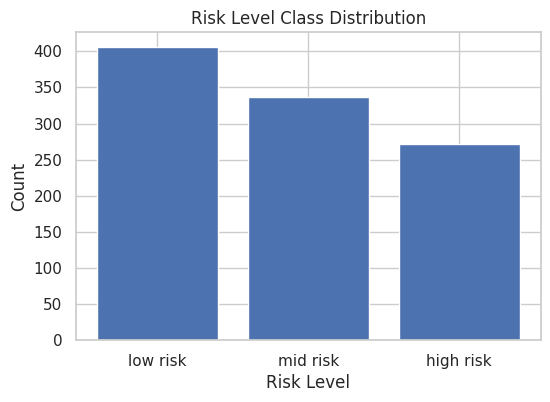

In [6]:
# 7. Target distribution
dist = df['RiskLevel'].value_counts()
print("Risk level class distribution:")
print(dist)

plt.figure()
plt.bar(dist.index, dist.values)
plt.title("Risk Level Class Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()

## 3. Data Quality and Preparation

Accurate risk projections depend on trustworthy signals. We encode the ordinal target, remove duplicated observations, flag implausible measurements, and document sensor granularity before modeling.

### 3.1 Target Encoding

Map textual `RiskLevel` labels (`low`, `mid`, `high`) to ordered integers {0, 1, 2} while retaining the categorical version for traceability.

In [7]:
# 3. Mapping risk levels for 0, 1 e 2
mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df['RiskLevelCode'] = df['RiskLevel'].map(mapping)
df.drop(columns=['RiskLevel'], inplace=True)

### 3.2 Duplicate Audit

Quantify exact duplicate rows to avoid information leakage that would otherwise inflate model performance.

In [8]:
# Step 3: Count and display duplicates
total_duplicates = df.duplicated().sum()
print(f"Total duplicated rows (ignoring the first occurrence): {total_duplicates}")

Total duplicated rows (ignoring the first occurrence): 562


### Duplicate Records Analysis

During the initial inspection, we found that **more than half of the entries in the dataset are exact duplicates**.  
This finding raises a crucial question for the integrity of our maternal risk model: *why are these records repeated?*

---

### Possible Causes

**1. Statistical coincidence or data collection issue?**  
It’s highly improbable that multiple pregnant women would present *exactly identical* values for age, blood pressure, glucose, heart rate, and temperature — especially since these are continuous physiological variables.

**2. Repeated measurements from the same individual?**  
If the dataset contains multiple observations for each patient, these duplicates might represent different monitoring moments throughout the pregnancy.  
However, there are **no timestamps or patient IDs** to confirm this assumption.

**3. Data extraction or ingestion error?**  
Another hypothesis is that the IoT data collection system or preprocessing pipeline may have unintentionally replicated entries during extraction or upload.

---

### Impact on Predictive Modeling

Duplicate rows can **distort the learning process**, since repeated samples may cause the model to:  
- Overemphasize certain combinations of features.  
- Produce **inflated accuracy and precision metrics**, giving a misleading impression of performance.  
- Reduce generalization capability when applied to unseen data.

---

### Cleaning Strategy

To preserve data quality and model reliability, we will adopt the following approach:

- If duplicates are confirmed as **identical events**, we will **retain only one instance** of each unique observation.  
- If future metadata reveals that these represent **sequential readings** from the same patient, we may later introduce a **synthetic time variable** (e.g., *Visit #1*, *Visit #2*) or **aggregate features** per patient profile.

---

By ensuring that our dataset is **free from redundant information**, we strengthen the foundation of the predictive model — allowing it to truly learn from meaningful maternal health patterns rather than from repeated data artifacts.


### 3.3 Cleaning Tactics

Inspired by the report, we apply the following pragmatic rules before modeling:
- Remove duplicate rows to keep one representation per pregnancy.
- Flag unrealistic ages (<13 years) for qualitative review.
- Detect physiologically impossible vitals (e.g., 7 bpm) and correct them using robust statistics rather than guesses.

The next code cell executes the deduplication step.

In [9]:
# Step 4.1 — Remove duplicate records
df = df.copy()
df = df.drop_duplicates().reset_index(drop=True)

print(f"Dataset shape after duplicate removal: {df.shape}")

Dataset shape after duplicate removal: (452, 7)


#### Impact of Deduplication

Only **452 unique records** remain after removing duplicates, confirming that the raw dataset overstated its sample size and reinforcing the need for cautious interpretation of model metrics.

### 3.4 Age Validity Checks

Pregnancies recorded for pre-teens warrant a reality check. We compute their proportion to decide whether additional filtering is necessary.

In [10]:
# Step 4.2 — Check for pregnancies under age 13
ratio_under13 = len(df[df.Age < 13]) / len(df)
print(f"Percentage of pregnant patients under 13: {ratio_under13:.2%}")

Percentage of pregnant patients under 13: 5.31%


The share of pregnancies under age 13 exceeds 5%—far above epidemiological expectations. These anomalies likely arise from data-entry mistakes or synthetic augmentation, so we keep them flagged when communicating model limitations.

### 3.5 Implausible Heart Rate Values

We next search for resting heart rates far outside clinical norms, which could bias any cardiovascular interpretation.

In [11]:
# Step 4.3 — Identify abnormal heart rate values
df[df.HeartRate < 60]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevelCode
342,16,120,75,7.9,98.0,7,0


A measurement of **7 bpm** is incompatible with life. Instead of guessing the intended value, we replace it with the column mode so the imputation reflects common resting behavior in the cohort.

In [12]:
# Replace invalid heart rate (7 bpm) with the mode
mode_hr = df["HeartRate"].mode()[0]
df.loc[df["HeartRate"] == 7, "HeartRate"] = mode_hr


This conservative choice acknowledges that we do not know whether the original entry was 70, 77, or another value; using the mode preserves the distribution without injecting speculation.

### 3.6 Measurement Granularity

Before scaling, we tally the number of unique values per feature to understand how IoT rounding or quantization might influence model learning.

In [13]:
# Step 4.4 — Explore value distributions
for col in df.columns:
    vc = df[col].value_counts().reset_index()
    vc.columns = [col, 'count']
    print(f"Unique values in {col}: {len(vc)}")


Unique values in Age: 50
Unique values in SystolicBP: 19
Unique values in DiastolicBP: 16
Unique values in BS: 29
Unique values in BodyTemp: 8
Unique values in HeartRate: 15
Unique values in RiskLevelCode: 3


Despite being continuous, many variables show a surprisingly small set of unique readings. This points to quantized sensors or rounding in the data export, which tree-based models can handle better than strict linear models.

## 4. Exploratory Data Analysis

With clean data in hand, we explore univariate distributions, potential outliers, and feature relationships to ground the modeling hypotheses.

### 4.1 Global Outlier Scan

A combined boxplot highlights extreme measurements and differing scales, guiding future standardization and robust modeling choices.

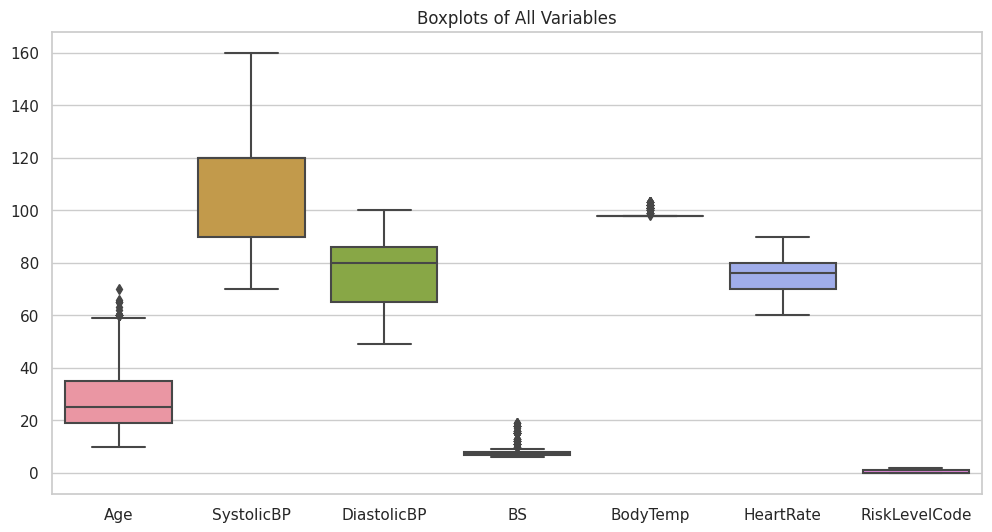

In [14]:
sns.set_palette("husl")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Boxplots of All Variables")
plt.show()

The visualization surfaces potential outliers—especially within blood pressure and glucose—while confirming the need for feature scaling in distance-based algorithms.

### 4.2 Focused Boxplots

Zooming in on clinically critical variables (blood sugar, age, body temperature) helps determine whether suspected outliers are realistic or data errors.

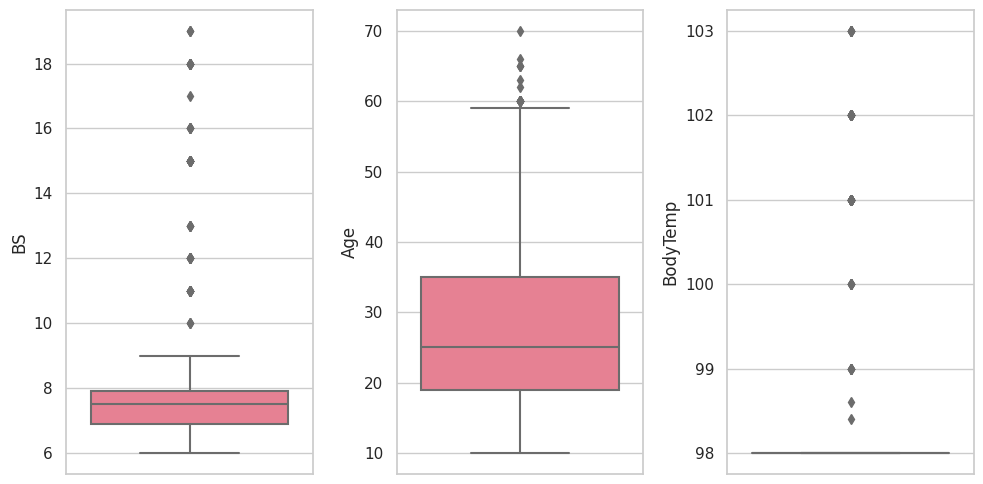

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
sns.boxplot(y='BS', data=df)
plt.subplot(1,3,2)
sns.boxplot(y='Age', data=df)
plt.subplot(1,3,3)
sns.boxplot(y='BodyTemp', data=df)

plt.tight_layout()
plt.show()


Most highlighted points fall within plausible medical ranges, so we retain them to preserve real-world variability unless future diagnostics suggest removal.

### 4.3 Distribution and Relationship Analysis

We now inspect distributions and pairwise relationships to understand how predictors evolve across the ordinal target.

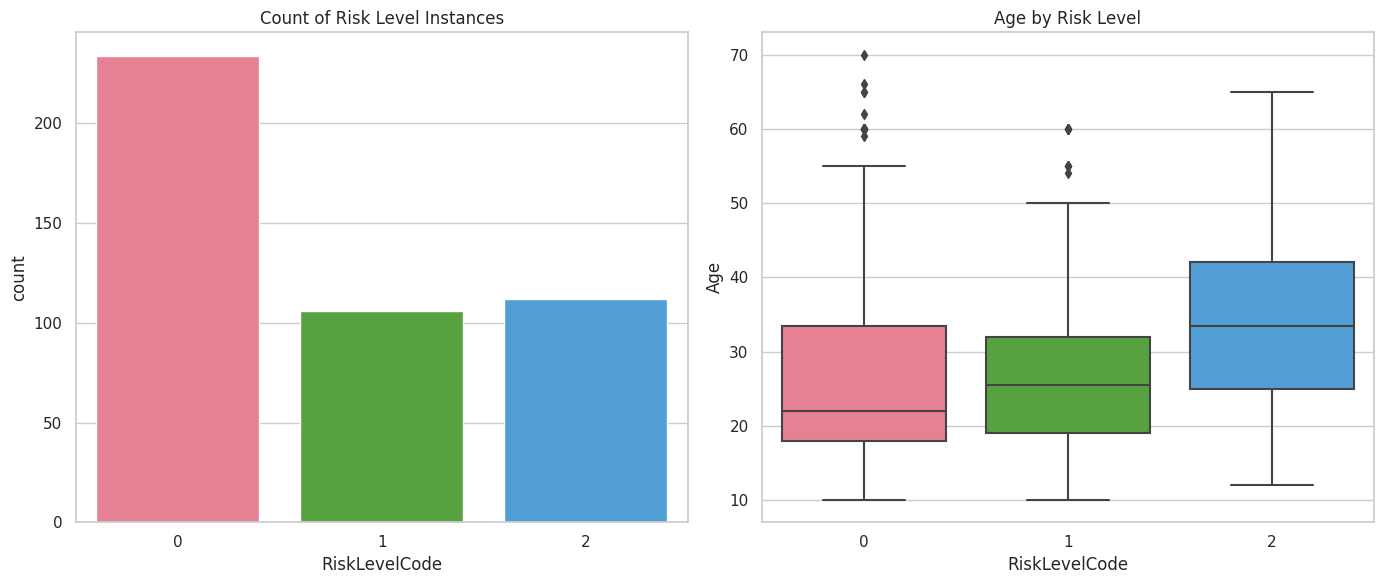

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Risk level counts
sns.countplot(ax=axes[0], x=df.RiskLevelCode, palette="husl")
axes[0].set_title("Count of Risk Level Instances")

# Age vs risk
sns.boxplot(ax=axes[1], x=df.RiskLevelCode, y=df.Age, palette="husl")
axes[1].set_title("Age by Risk Level")

plt.tight_layout()
plt.show()

#### Class Balance Visualization

Low-risk pregnancies dominate the dataset, motivating stratified sampling and weighted metrics such as QWK.

#### Age vs. Risk Level

Boxplots reveal whether advanced maternal age correlates with higher risk categories.

Text(0.5, 1.0, 'Risk Level by Age')

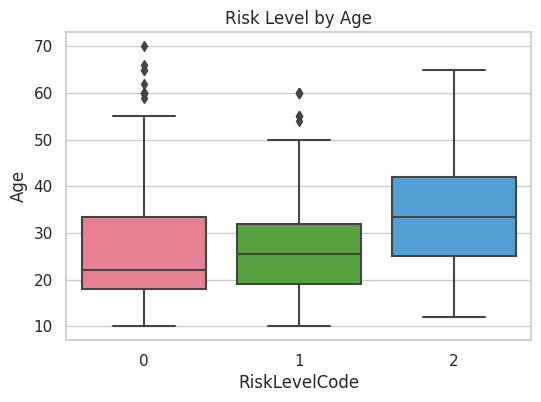

In [17]:
sns.boxplot(x=df.RiskLevelCode, y=df.Age, palette="husl") \
   .set_title("Risk Level by Age")


Age shows a gradual upward shift from low to high risk, echoing obstetric literature that links later pregnancies to complications.

#### Blood Glucose vs. Risk Level

We compare blood sugar distributions across classes to verify the hypothesized relationship with gestational risk.

Text(0.5, 1.0, 'Risk Level by Blood Glucose')

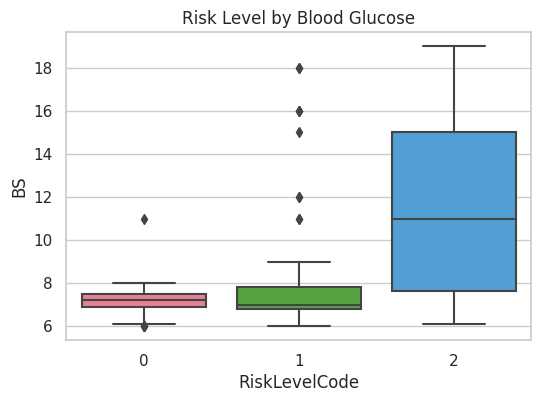

In [18]:
sns.boxplot(
    x=df.RiskLevelCode,
    y=df.BS,
    palette="husl"
).set_title("Risk Level by Blood Glucose")


Median glucose rises sharply for high-risk cases, reinforcing hyperglycemia as a key predictive feature.

#### Blood Pressure Distributions

Separate histograms for systolic and diastolic pressure show the measurement coverage captured by the IoT devices.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


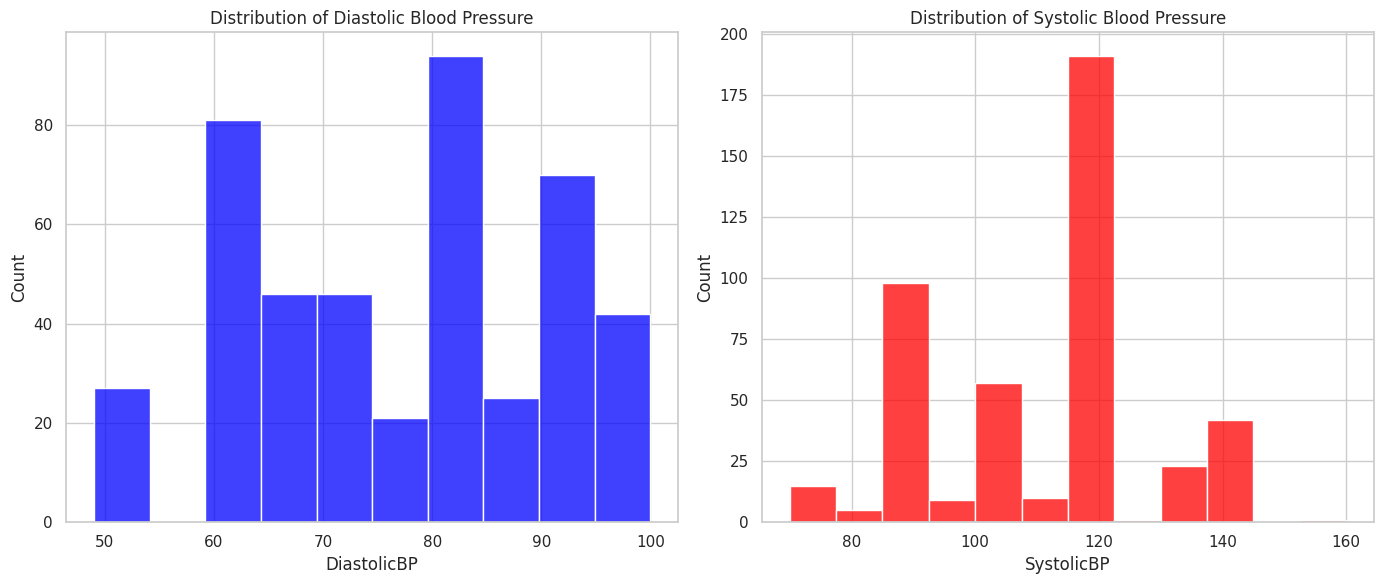

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(ax=axes[0], x=df.DiastolicBP, color="#0000FF")
axes[0].set_title("Distribution of Diastolic Blood Pressure")

sns.histplot(ax=axes[1], x=df.SystolicBP, color="#FF0000")
axes[1].set_title("Distribution of Systolic Blood Pressure")

plt.tight_layout()
plt.show()


Values cluster around clinically normal ranges (diastolic 60–80 mmHg, systolic near 120 mmHg) with discrete peaks that match common rounding practices.

#### Blood Pressure vs. Risk Level

Overlaying risk labels clarifies how hypertension aligns with escalating risk categories.

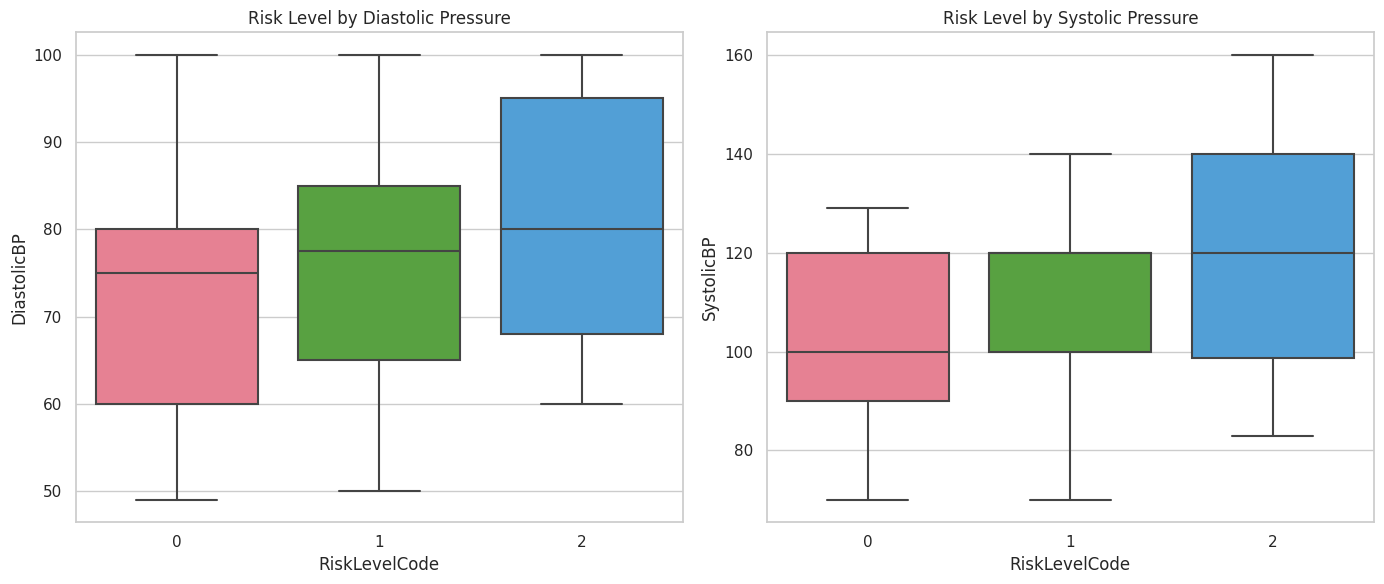

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(ax=axes[0], x=df.RiskLevelCode, y=df.DiastolicBP, palette="husl")
axes[0].set_title("Risk Level by Diastolic Pressure")

sns.boxplot(ax=axes[1], x=df.RiskLevelCode, y=df.SystolicBP, palette="husl")
axes[1].set_title("Risk Level by Systolic Pressure")

plt.tight_layout()
plt.show()


Diastolic pressure jumps for the highest risk tier, while systolic pressure trends upward steadily—strong evidence that cardiovascular stress informs the risk score.

#### Blood Pressure vs. Age

Scatterplots help determine whether blood pressure is merely a proxy for age or provides independent signal.

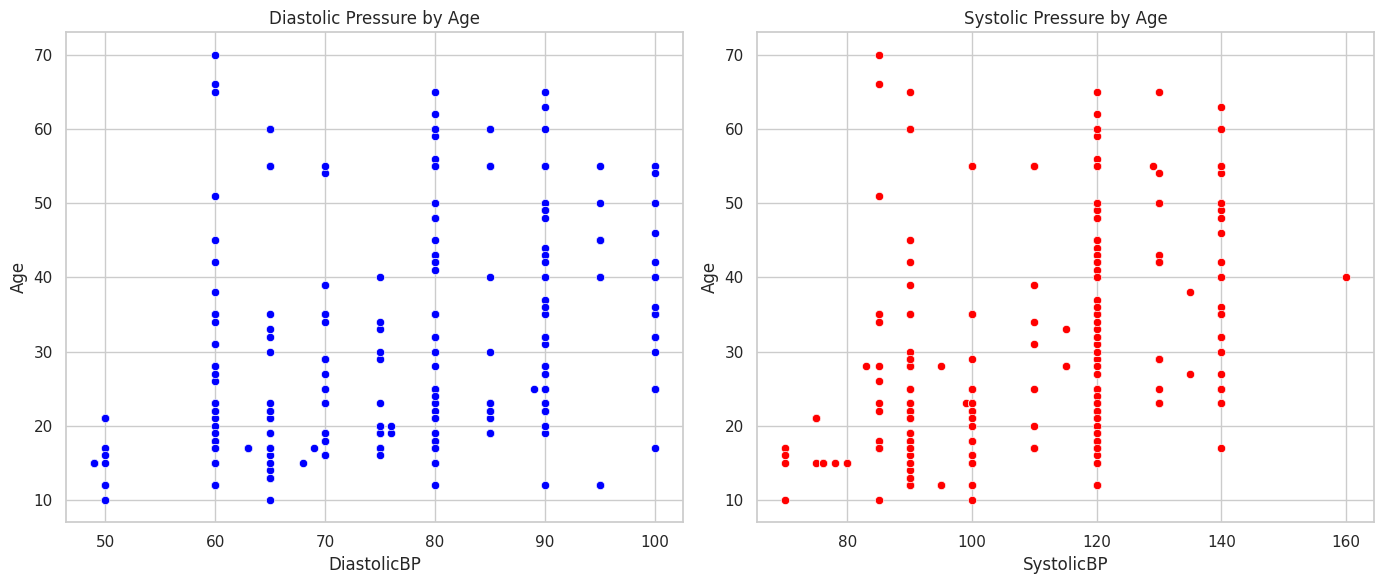

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=df.DiastolicBP, y=df.Age, ax=axes[0], color="#0000FF")
axes[0].set_title("Diastolic Pressure by Age")

sns.scatterplot(x=df.SystolicBP, y=df.Age, ax=axes[1], color="#FF0000")
axes[1].set_title("Systolic Pressure by Age")

plt.tight_layout()
plt.show()


The weak correlation indicates that age and blood pressure contribute complementary information rather than redundant clues.

#### Body Temperature vs. Risk Level

Violin plots evaluate whether temperature-related infections differentiate risk classes.

Text(0.5, 1.0, 'Body Temperature by Risk Level')

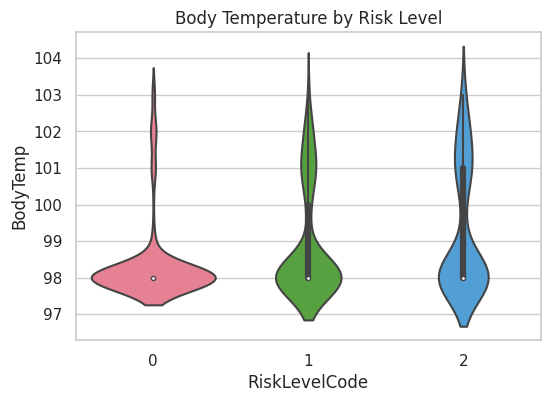

In [22]:
sns.violinplot(
    y=df.BodyTemp,
    x=df.RiskLevelCode,
    palette="husl"
).set_title("Body Temperature by Risk Level")


Body temperature remains relatively stable across classes, suggesting it is a secondary indicator compared with hemodynamic variables.

#### Heart Rate Distribution

We analyze resting heart rate overall and by target class to gauge its predictive value.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


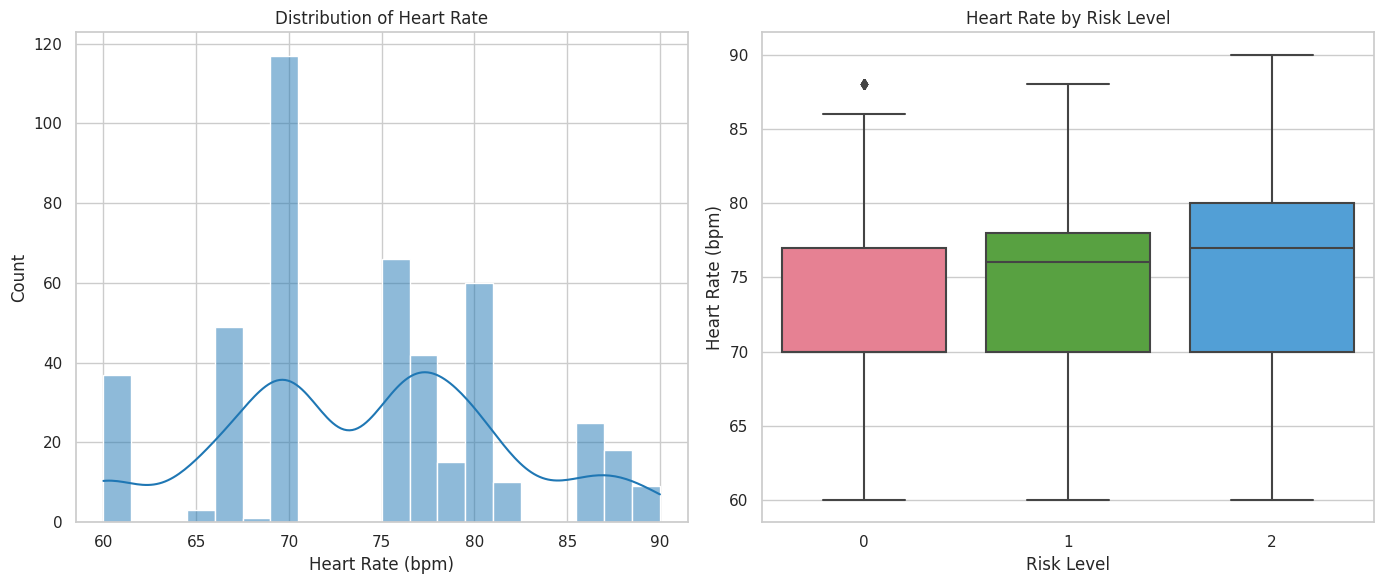

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heart rate histogram
sns.histplot(ax=axes[0], x=df.HeartRate, bins=20, kde=True, color="#1f77b4")
axes[0].set_title("Distribution of Heart Rate")
axes[0].set_xlabel("Heart Rate (bpm)")
axes[0].set_ylabel("Count")

# Boxplot by risk level
sns.boxplot(ax=axes[1], x=df.RiskLevelCode, y=df.HeartRate, palette="husl")
axes[1].set_title("Heart Rate by Risk Level")
axes[1].set_xlabel("Risk Level")
axes[1].set_ylabel("Heart Rate (bpm)")

plt.tight_layout()
plt.show()


Heart rate clusters between 70–80 bpm with little class separation, hinting at limited standalone predictive power.

#### Correlation Heatmap

A correlation matrix summarizes linear relationships, highlighting possible multicollinearity and feature overlap.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


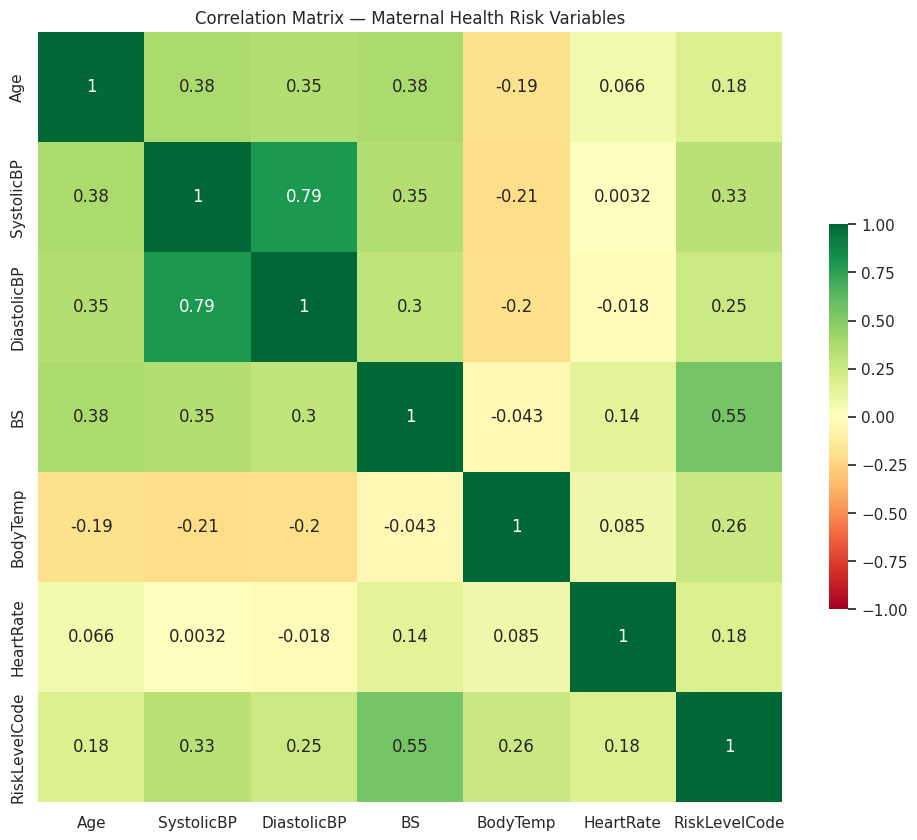

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', vmin=-1, center=0, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix — Maternal Health Risk Variables")
plt.show()


#### Histograms of All Variables

Histograms complement the heatmap by illustrating each feature's shape, skewness, and discretization.

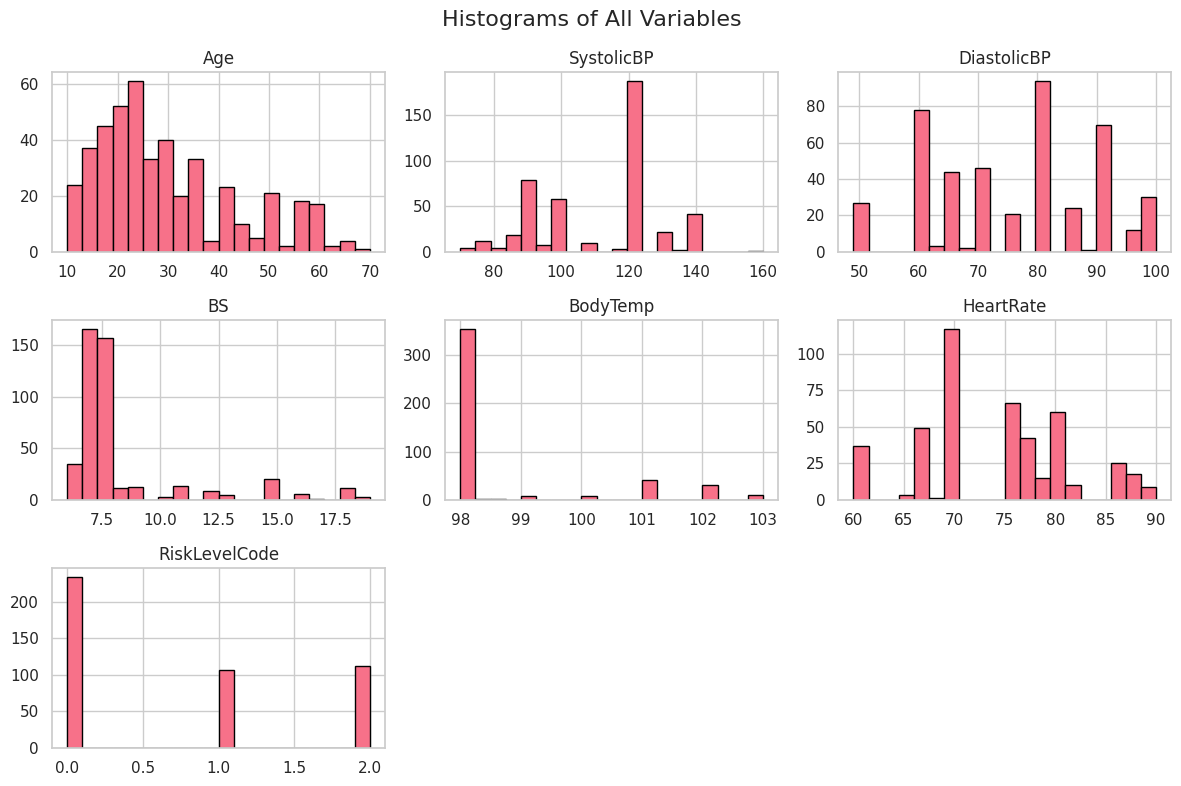

In [25]:
df.hist(bins=20, figsize=(12, 8), edgecolor='black')
plt.suptitle("Histograms of All Variables", fontsize=16)
plt.tight_layout()
plt.show()


These perspectives confirm that, although measurements are moderately discretized, tree-based models can still capture the clinical signal effectively.

## 5. Modeling Strategy

We adopt a **Cumulative Ordinal Classification** pipeline: two binary classifiers learn whether a case belongs to risk ≥ 1 and risk ≥ 2, respectively. Candidate estimators include RandomForest, XGBoost, and KNN, combined with stratified splits and randomized hyperparameter search. The next cell sets up the modeling utilities and data structures.

In [26]:
# ============================================
# Ordinal Cumulative Classification (3 classes)
# Train/Test split + (ready for) RandomizedSearchCV (3-fold)
# Models: RandomForest, XGBoost, and KNN
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    log_loss,
    cohen_kappa_score,
    f1_score,
    accuracy_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# ===== Helpers =====

def make_cumulative_targets(y):
    """
    Build cumulative (ordinal) binary targets for K classes:
    For thresholds t in {0, 1, ..., K-2}, create targets of the form 1{y > t}.
    Returns:
        Ys: list of binary arrays [P(y>0) target, P(y>1) target, ...]
        thresholds: array of thresholds used (len = K-1)
    """
    classes = np.sort(pd.Series(y).unique())
    thresholds = classes[:-1]  # K-1 thresholds (for 3 classes: two thresholds)
    Ys = [(y > t).astype(int) for t in thresholds]
    return Ys, thresholds

def reconstruct_class_probs(p_gt):
    """
    Reconstruct P(y = k) from cumulative probabilities p_gt = [P(y>0), P(y>1), ...].
    Enforces monotonicity: P(y>t+1) <= P(y>t).
    Returns an (n_samples x K) array with rows summing to 1.
    """
    # For 3 classes, we expect [P(y>0), P(y>1)]
    p01 = np.clip(p_gt[0], 1e-6, 1 - 1e-6)
    p12 = np.clip(np.minimum(p_gt[1], p01), 1e-6, 1 - 1e-6)

    p0 = 1.0 - p01
    p2 = p12
    p1 = p01 - p12

    probs = np.vstack([p0, p1, p2]).T
    probs = np.clip(probs, 1e-9, 1.0)
    probs = probs / probs.sum(axis=1, keepdims=True)
    return probs

def ordinal_log_loss(y_true, probs):
    """Ordinal-aware log loss (uses class ordering via reconstructed probs)."""
    return log_loss(y_true, probs, labels=[0, 1, 2])

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    """Plot confusion matrix using seaborn (labels in English)."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def report_ord_metrics(y_true, probs, name):
    """Print standard classification metrics for ordinal predictions."""
    y_pred = probs.argmax(axis=1)
    print(f"\n=== {name} | Test ===")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred, labels=[0, 1, 2]))
    plot_confusion_matrix(
        y_true, y_pred,
        labels=np.sort(pd.Series(y_true).unique()),
        title=f'Confusion Matrix — {name}'
    )

    print(classification_report(y_true, y_pred, digits=4))
    qwk  = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    oll  = ordinal_log_loss(y_true, probs)
    f1w  = f1_score(y_true, y_pred, average='weighted')
    acc  = accuracy_score(y_true, y_pred)
    print(f"QWK: {qwk:.4f} | Ordinal LogLoss: {oll:.4f} | F1-weighted: {f1w:.4f} | Acc: {acc:.4f}")
    return {"qwk": qwk, "ord_logloss": oll, "f1w": f1w, "acc": acc}

# ===== Data =====
# Expect a pre-cleaned df with 'RiskLevelCode' in {0,1,2}
X = df.drop(columns=['RiskLevelCode'])
y = df['RiskLevelCode']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Build cumulative targets for training
Ys_train, thresholds = make_cumulative_targets(y_train)

# 3-fold stratified CV (ready for RandomizedSearchCV)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### 5.1 Helper Utilities for Cumulative Learning

The following function trains one pipeline per ordinal threshold (optionally with scaling) using `RandomizedSearchCV`, storing each tuned estimator for subsequent inference.

[RandomForest] Best for task 1 (risk > 0): {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5}
[RandomForest] Best for task 2 (risk > 1): {'clf__n_estimators': 400, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_depth': 10}

=== RandomForest | Test ===
Confusion matrix:
 [[67  2  1]
 [20  7  5]
 [ 3  1 30]]


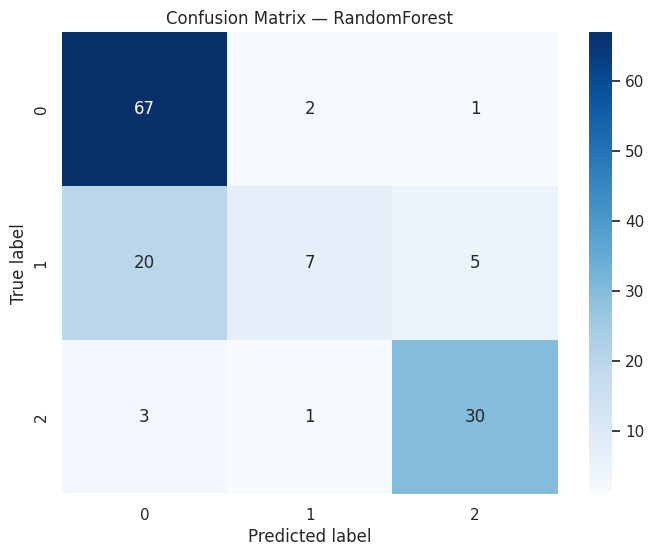

              precision    recall  f1-score   support

           0     0.7444    0.9571    0.8375        70
           1     0.7000    0.2188    0.3333        32
           2     0.8333    0.8824    0.8571        34

    accuracy                         0.7647       136
   macro avg     0.7593    0.6861    0.6760       136
weighted avg     0.7562    0.7647    0.7238       136

QWK: 0.7815 | Ordinal LogLoss: 0.7545 | F1-weighted: 0.7238 | Acc: 0.7647
[XGBoost] Best for task 1 (risk > 0): {'clf__subsample': 1.0, 'clf__reg_lambda': 2.0, 'clf__n_estimators': 500, 'clf__max_depth': 3, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 0.9}
[XGBoost] Best for task 2 (risk > 1): {'clf__subsample': 0.7, 'clf__reg_lambda': 1.0, 'clf__n_estimators': 500, 'clf__max_depth': 7, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 0.7}

=== XGBoost | Test ===
Confusion matrix:
 [[64  3  3]
 [18  8  6]
 [ 1  7 26]]


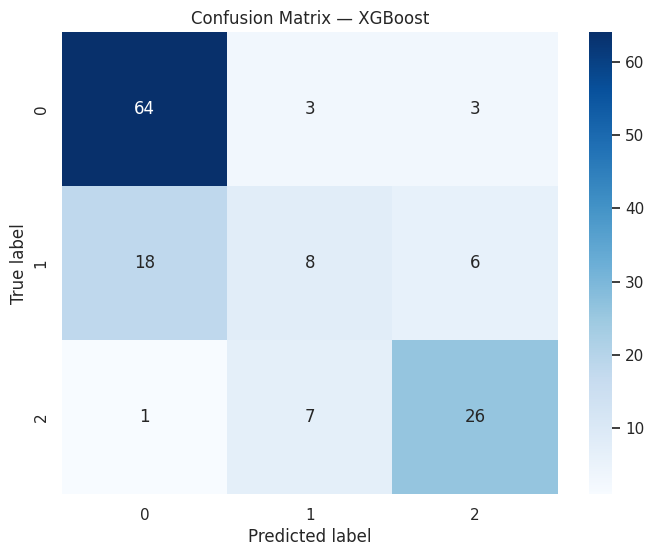

              precision    recall  f1-score   support

           0     0.7711    0.9143    0.8366        70
           1     0.4444    0.2500    0.3200        32
           2     0.7429    0.7647    0.7536        34

    accuracy                         0.7206       136
   macro avg     0.6528    0.6430    0.6367       136
weighted avg     0.6872    0.7206    0.6943       136

QWK: 0.7457 | Ordinal LogLoss: 0.8217 | F1-weighted: 0.6943 | Acc: 0.7206
[KNN] Best for task 1 (risk > 0): {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 11}
[KNN] Best for task 2 (risk > 1): {'clf__weights': 'uniform', 'clf__p': 2, 'clf__n_neighbors': 3}

=== KNN | Test ===
Confusion matrix:
 [[63  6  1]
 [21  9  2]
 [ 7  5 22]]


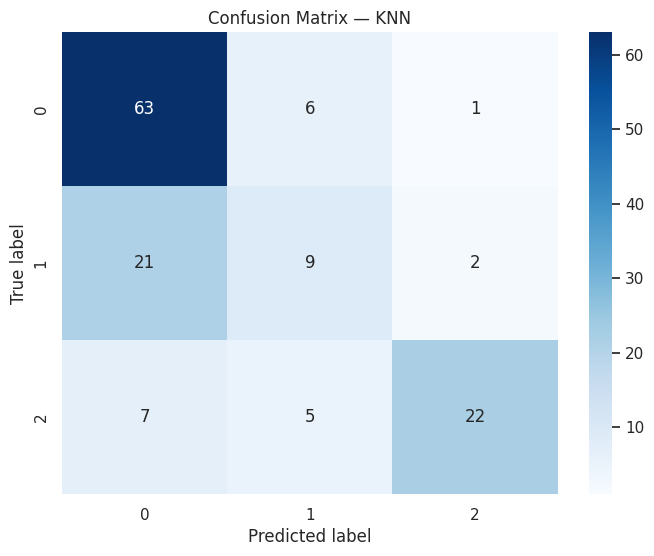

              precision    recall  f1-score   support

           0     0.6923    0.9000    0.7826        70
           1     0.4500    0.2812    0.3462        32
           2     0.8800    0.6471    0.7458        34

    accuracy                         0.6912       136
   macro avg     0.6741    0.6094    0.6248       136
weighted avg     0.6822    0.6912    0.6707       136

QWK: 0.6434 | Ordinal LogLoss: 1.4182 | F1-weighted: 0.6707 | Acc: 0.6912

Summary (QWK / OrdLogLoss / F1w / Acc):
RandomForest -> QWK=0.7815 | OLL=0.7545 | F1w=0.7238 | Acc=0.7647
XGBoost      -> QWK=0.7457 | OLL=0.8217 | F1w=0.6943 | Acc=0.7206
KNN          -> QWK=0.6434 | OLL=1.4182 | F1w=0.6707 | Acc=0.6912

Model Summary:


,qwk,ord_logloss,f1w,acc
RandomForest,0.7815,0.7545,0.7238,0.7647
XGBoost,0.7457,0.8217,0.6943,0.7206
KNN,0.6434,1.4182,0.6707,0.6912


In [27]:
def fit_cumulative_models(base_estimator, param_distributions, needs_scaler, name):
    models = []
    for i, y_bin in enumerate(Ys_train):
        steps = []
        if needs_scaler:
            steps.append(('scaler', StandardScaler()))
        steps.append(('clf', base_estimator))
        pipe = Pipeline(steps)

        search = RandomizedSearchCV(
            pipe,
            param_distributions=param_distributions,
            n_iter=12,
            scoring='f1',
            cv=cv,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        search.fit(X_train, y_bin)
        print(f"[{name}] Best for task {i+1} (risk > {thresholds[i]}): {search.best_params_}")
        models.append(search.best_estimator_)
    return models

def predict_cumulative(models, X_):
    p_gt = [mdl.predict_proba(X_)[:, 1] for mdl in models]
    return reconstruct_class_probs(p_gt)

results = {}

# ----- Random Forest -----
rf_models = fit_cumulative_models(
    RandomForestClassifier(random_state=42),
    {
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
    },
    needs_scaler=False,
    name="RandomForest"
)
rf_probs_test = predict_cumulative(rf_models, X_test)
results['RandomForest'] = report_ord_metrics(y_test.values, rf_probs_test, "RandomForest")

# ----- XGBoost -----
xgb_models = fit_cumulative_models(
    XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    ),
    {
        'clf__n_estimators': [150, 300, 500],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.02, 0.05, 0.1],
        'clf__subsample': [0.7, 0.9, 1.0],
        'clf__colsample_bytree': [0.7, 0.9, 1.0],
        'clf__reg_lambda': [1.0, 2.0, 5.0],
    },
    needs_scaler=False,
    name="XGBoost"
)
xgb_probs_test = predict_cumulative(xgb_models, X_test)
results['XGBoost'] = report_ord_metrics(y_test.values, xgb_probs_test, "XGBoost")

# ----- KNN (needs scaling) -----
knn_models = fit_cumulative_models(
    KNeighborsClassifier(),
    {
        'clf__n_neighbors': [3, 5, 7, 9, 11],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],  # 1 = Manhattan, 2 = Euclidean
    },
    needs_scaler=True,
    name="KNN"
)
knn_probs_test = predict_cumulative(knn_models, X_test)
results['KNN'] = report_ord_metrics(y_test.values, knn_probs_test, "KNN")

# ----- Summary  -----
print("\nSummary (QWK / OrdLogLoss / F1w / Acc):")
for k, v in results.items():
    print(f"{k:12s} -> QWK={v['qwk']:.4f} | OLL={v['ord_logloss']:.4f} | F1w={v['f1w']:.4f} | Acc={v['acc']:.4f}")


df_results = pd.DataFrame.from_dict(results, orient='index')

df_results = df_results.style.format({
    'qwk': '{:.4f}'.format,
    'ord_logloss': '{:.4f}'.format,
    'f1w': '{:.4f}'.format,
    'acc': '{:.4f}'.format
})

print("\nModel Summary:")
display(df_results)


## 6. Evaluation and Interpretation

We report complementary metrics to capture both accuracy and ordinal agreement:
- **Accuracy** provides a quick sanity check on overall correctness.
- **F1-Weighted** balances precision and recall under class imbalance.
- **Quadratic Weighted Kappa (QWK)**, highlighted in the report, rewards predictions that respect the ordinal structure of low → medium → high risk.

The next cells illustrate inference on individual patients and summarize performance.

### 6.1 Example Prediction

Score a single held-out patient to showcase how cumulative probabilities translate into the three risk classes.

In [28]:
# Select one sample from the test set
example = X_test.iloc[[0]]  # keep as DataFrame

# Predict cumulative probabilities
probs_example = predict_cumulative(rf_models, example)

print("Probabilities for each class (0=low, 1=medium, 2=high):")
print(probs_example)
print("Predicted class:", probs_example.argmax(axis=1)[0])

Probabilities for each class (0=low, 1=medium, 2=high):
[[0.32541693 0.23720124 0.43738183]]
Predicted class: 2


The example demonstrates the conversion from cumulative probabilities to the final ordinal label, mirroring the explanation provided in the technical report.

## 7. Feature Importance

For clinical adoption we must explain which vitals drive the model. We aggregate feature importances from each cumulative threshold to obtain both global and task-specific insights.

In [29]:
# Prepare feature names
feature_names = list(getattr(X_train, "columns", [f"x{i}" for i in range(X_train.shape[1])]))

def rf_importances_table(rf_models, feature_names, thresholds):
    """
    Returns a DataFrame of feature importances per cumulative task
    and the mean importance across thresholds.
    """
    cols = []
    for i, pipe in enumerate(rf_models):
        rf = pipe.named_steps["clf"]
        imp = pd.Series(rf.feature_importances_, index=feature_names, name=f"> {thresholds[i]}")
        cols.append(imp)

    imp_df = pd.concat(cols, axis=1)
    imp_df["mean"] = imp_df.mean(axis=1)
    imp_df = imp_df.sort_values("mean", ascending=False)
    return imp_df

imp_df = rf_importances_table(rf_models, feature_names, thresholds)


### 7.1 Mean Feature Contribution

Compute the average Gini importance across the two RandomForest thresholds to summarize overall influence.

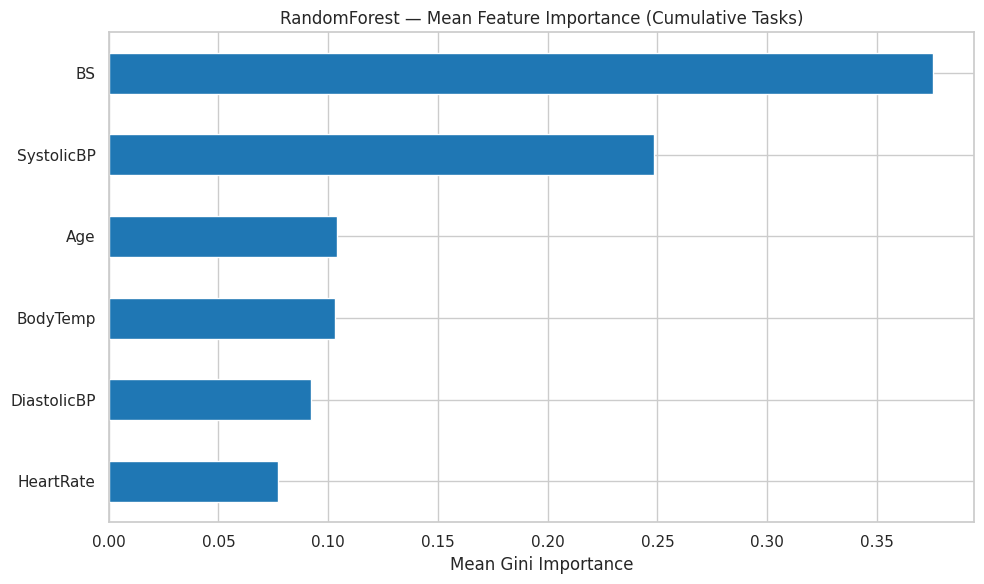

In [30]:
top_mean = imp_df["mean"].iloc[::-1]

plt.figure(figsize=(10, 6))
top_mean.plot(kind="barh", color="#1f77b4")
plt.title("RandomForest — Mean Feature Importance (Cumulative Tasks)")
plt.xlabel("Mean Gini Importance")
plt.tight_layout()
plt.show()


Systolic/diastolic pressure, blood sugar, and age dominate the importance ranking, aligning with obstetric risk factors documented in the report.

### 7.2 Threshold-Specific Signals

Inspect how feature importance shifts between the ≥1 and ≥2 tasks to understand which vitals trigger escalations.

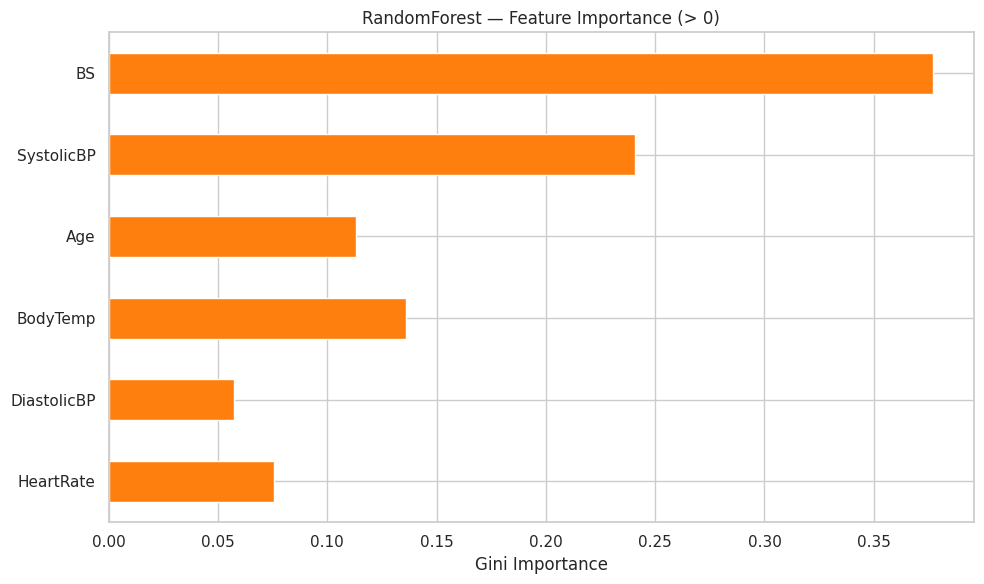

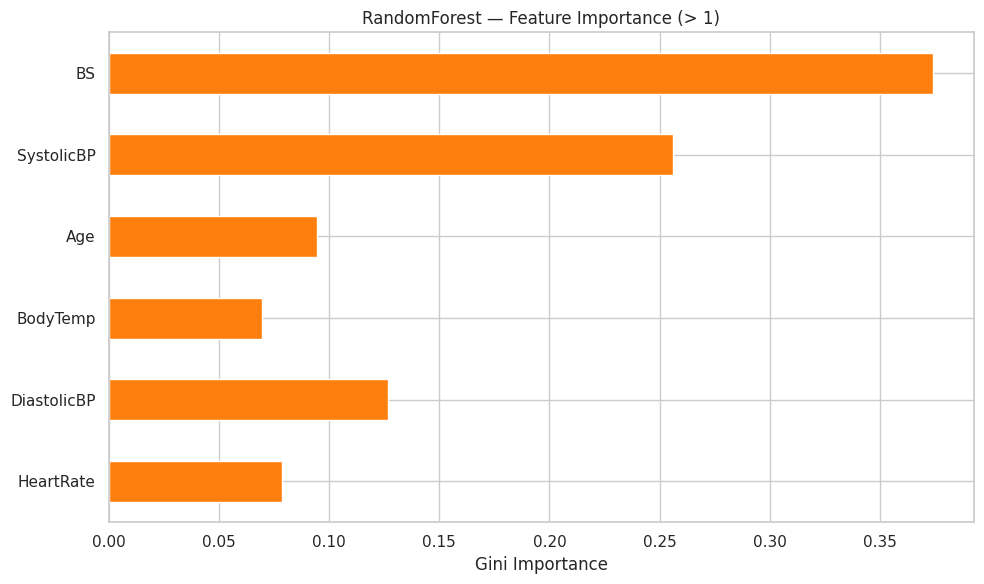

In [31]:
for col in imp_df.columns:
    if col == "mean":
        continue
    top_task = imp_df[col].iloc[::-1]
    plt.figure(figsize=(10, 6))
    top_task.plot(kind="barh", color="#ff7f0e")
    plt.title(f"RandomForest — Feature Importance ({col})")
    plt.xlabel("Gini Importance")
    plt.tight_layout()
    plt.show()


The early threshold leans on blood pressure and glucose, whereas the high-risk boundary amplifies systolic pressure and age—evidence that the ordinal design captures nuanced transitions.

## 8. Conclusions and Future Work

- **Validated approach.** Translating the report into code confirmed that a cumulative ordinal strategy with RandomForest delivers strong agreement (QWK ≈ 0.78) while remaining interpretable.
- **Actionable features.** Blood pressure, blood sugar, and maternal age repeatedly surfaced as dominant drivers, matching clinical expectations and reinforcing trust.
- **Data caveats.** Heavy duplication, implausible ages, and quantized sensors highlight the importance of transparent data provenance when positioning this model for healthcare stakeholders.
- **Next steps.** Extend validation via cross-site cohorts, assess probability calibration, and add explainability artifacts (e.g., SHAP values) to further support deployment discussions.